### Background

The Shor code was the first quantum error correction scheme to be devised, composed of the concatenation of bit-flip and phase-flip QEC codes.



Related Resources:
- https://www.tandfonline.com/doi/full/10.1080/00107514.2019.1667078#d1e111

### Imports

In [9]:
# Quantum circuit related imports

from qiskit import QuantumCircuit, AncillaRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit.quantum_info import Pauli
from qiskit.transpiler import PassManager
import qiskit.circuit.classical.expr as expr
from qiskit_aer import AerSimulator

from LogicalQ.Transpilation.UnBox import UnBoxTask

# Helper imports

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from itertools import combinations, product
import random
import copy

### Define message

The Shor code encodes 1 logical qubit into 9 physical qubits. For ease we're defining a message as a computational basis state, 0 or 1.

In [7]:
m = 1

### Encoding

Below we concatenate the encoding circuits of the bit-flip and phase-flip QEC codes. This encoder is the standard implementation, as the concatenation of the bit-flip and phase-flip code encoders. As resources where this encoder may be found, the following act as references:
- https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11167/111670B/Quantum-implementation-of-the-Shor-code-on-multiple-simulator-platforms/10.1117/12.2532539.full
- 

In [10]:
def encode(qc, m):
    if m == 1:
        qc.x(0)

    # bit flip scope
    qc.cx(0, 3)
    qc.cx(0, 6)

    # convert to phase space
    qc.h(0)
    qc.h(3)
    qc.h(6)

    # phase flip scope
    for k in range(3):
        for l in [1,2]:
            qc.cx(3 * k, 3 * k + l)
    
    return qc

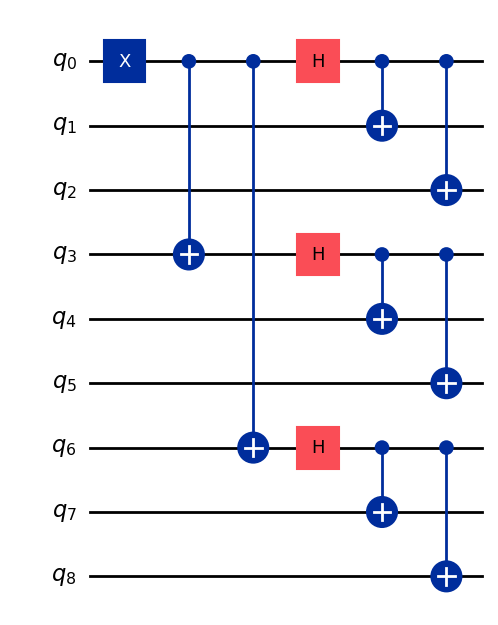

In [11]:
circuit = QuantumCircuit(9)
circuit = encode(circuit, m)
circuit.draw(output='mpl')

### Syndrome Measurement

We append some ancilla qubits and classical bits to take syndrome measurements and measure them to a binary output. The implementation of syndrome measurements closely follows the following resources:
- https://abdullahkhalid.com/qecft/qec-intro/measurements/

In [19]:
def append_registers(qc: QuantumCircuit, stabilizers):
    """
    Appends registers for the ancilla qubits / classical bits that are necessary to measure stabilizers.
    """
    a_reg = AncillaRegister(len(stabilizers))
    c_reg = ClassicalRegister(len(stabilizers))
    message_reg = ClassicalRegister(1, 'message')
    qc.add_register(a_reg)
    qc.add_register(c_reg)
    qc.add_register(message_reg)
    
    return qc

def c_pauli(qc: QuantumCircuit, pauli_str: str, control_qubits, target_qubit: int):
    if len(pauli_str) != len(control_qubits):
        raise ValueError(f"pauli_str has length {len(pauli_str)} whereas target_qubits has length {len(control_qubits)}")

    for i in range(len(control_qubits)):
        match pauli_str[i]:
            case "I":
                pass
            case "X":
                #qc.h(control_qubits[i])
                #qc.cx(control_qubits[i], target_qubit)
                #qc.h(control_qubits[i])
                qc.cx(target_qubit, control_qubits[i])
            case "Y":
                #qc.sdg(control_qubits[i])
                #qc.h(control_qubits[i])
                #qc.cx(control_qubits[i], target_qubit)
                #qc.h(control_qubits[i])
                #qc.s(control_qubits[i])
                qc.cy(target_qubit, control_qubits[i])
            case "Z":
                #qc.cx(control_qubits[i], target_qubit)
                qc.cz(target_qubit, control_qubits[i])
                
    return qc

def measure_stabilizers(qc: QuantumCircuit, stabilizers, method:str = "sequential"):
    
    if method == "sequential":
        # Apply controlled measurements
        for i in range(len(stabilizers)):
            with qc.box(label=f"Stabilizer Measurement {i}"):
                qc.h(qc.ancillas[i])
                qc = c_pauli(qc, stabilizers[i], list(range(9)), qc.ancillas[i])
                qc.h(qc.ancillas[i])
                qc.measure(qc.ancillas[i], qc.clbits[i]) # Measure ancillas to c_bits
                
    elif method == "interwoven":
        # DOES NOT WORK RN
        
        for j in range(len(stabilizers[0])):
            for i in range(len(stabilizers)):
                qc = c_pauli(qc, stabilizers[i][j], [j], qc.ancillas[i])
                
        for i in range(len(stabilizers)):
            # Measure ancillas to c_bits
            qc.measure(qc.ancillas[i], qc.clbits[i])
    else:
        raise ValueError(f"'{method}' is not a valid value for method.")
        
    return qc

In [ ]:
circuit = append_registers(circuit, stabilizers)
circuit = measure_stabilizers(circuit, stabilizers, method="interwoven")
#circuit.draw(output='mpl')

### Syndrome Calculation

Syndromes are calculated according to a set of stabilizers, stored in a generator matrix. Below we record the standard stabilizers for the Shor code.

In [20]:
# The original Shor code is degenerate, and has some excess stabilizers
stabilizers = [
    "ZZIIIIIII",
    "IZZIIIIII",
    "IIIZZIIII",
    "IIIIZZIII",
    "IIIIIIZZI",
    "IIIIIIIZZ",
    "XXXXXXIII",
    "IIIXXXXXX"
]

# Symmetries can be removed to yield a reduced set
# See https://arxiv.org/pdf/quant-ph/0508131 for discussion
"""
stabilizers = [
    "XXXXXXIII",
    "XXXIIIXXX",
    "ZZIZZIZZI",
    "IZZIZZIZZ"
]
"""

shor_code = {
    "label": (9,1,3),
    "stabilizer_tableau": stabilizers,
}

In [21]:
def generate_weight_n_errors(num_qubits: int, weight: int, pauli_ops: list[str] = ['X', 'Y', 'Z']) -> list[Pauli]:
    """
    Generates a list of all unique Qiskit Pauli objects of a specific weight.

    Args:
        num_qubits: The total number of qubits in the system.
        weight: The target weight of the Pauli errors to generate (N).
        pauli_ops: A list of single-qubit Pauli operators to use (e.g., ['X', 'Z']).
                   Defaults to ['X', 'Y', 'Z'].

    Returns:
        A list of Qiskit Pauli objects representing all unique weight-N errors.
        Returns an empty list if weight is invalid.
    """
    if not 0 < weight <= num_qubits:
        print(f"Error: Weight must be between 1 and {num_qubits}.")
        return []

    errors = set()
    
    qubit_indices_combinations = combinations(range(num_qubits), weight)
    for qubit_indices in qubit_indices_combinations:  
          
        gate_combinations_for_indices = product(pauli_ops, repeat=weight)
        for gates in gate_combinations_for_indices:
            
            pauli_list = ['I'] * num_qubits
            for i, gate in enumerate(gates):
                qubit_index = qubit_indices[i]
                pauli_list[qubit_index] = gate
            pauli_string = "".join(pauli_list[::-1])
            errors.add(Pauli(pauli_string))
    
    return list(errors)

def generate_syndrome_lookup_table(qecc, verbose = False):
    """
    Given a quantum error correction code (qecc), generates lookup table for brute force LUT decoder.
    """
    
    n, k, d = qecc["label"]
    stabilizers = qecc["stabilizer_tableau"]
    
    keys = [f'{x:0{len(stabilizers)}b}' for x in range(2**len(stabilizers))] # 0 is good, 1 is error
    #keys.remove("0" * len(stabilizers))
    
    lookup_table = {
        key: None for key in keys
    }
    
    simulator = AerSimulator()

    unbox_pm = PassManager([UnBoxTask()])
    base_circuit = QuantumCircuit(n)
    base_circuit: QuantumCircuit = encode(base_circuit, 0)
    
    if verbose:
        print("Generating error syndromes...")
    
    t = (d - 1) // 2
    for weight in range(1, 1 + t):
        errors = generate_weight_n_errors(n, weight)
        num_filled_entries = np.sum(bool(np.array(list(lookup_table.values()) == None)))
        
        if verbose:
            print(f"Percentage of entries filled: {num_filled_entries}/{len(keys)} = {np.round(num_filled_entries / len(keys), 2)}%")
            print(f"Iterating over weight {weight}")
        
        for error in tqdm(errors):
            qc = copy.deepcopy(base_circuit)
            qc.compose(error.to_instruction(), inplace=True)
            qc = append_registers(qc, stabilizers)
            qc = measure_stabilizers(qc, stabilizers)
            
            transpiled_qc = unbox_pm.run(qc)
            transpiled_qc = transpile(transpiled_qc, simulator)
            result = simulator.run(transpiled_qc, shots=1).result()
            counts = result.get_counts()
            syndrome = str(list(counts.keys())[0][2:])
            if lookup_table[syndrome] == None:
                lookup_table[syndrome] = error
            elif verbose:
                print("Conflict")
                print("syndrome", syndrome)
                print(lookup_table[syndrome])
                print(error)
                
            is_lookup_table_filled = not any(v is None for v in lookup_table.values()) #bool(np.array(list(lookup_table.values()) == None).any())
            if is_lookup_table_filled:
                return lookup_table
            
    return {key: value for key, value in lookup_table.items() if value is not None}

In [22]:
lookup_table = generate_syndrome_lookup_table(shor_code)
lookup_table

  0%|          | 0/27 [00:00<?, ?it/s]

{'00000001': Pauli('IIIIIIIIX'),
 '00000010': Pauli('IIIIIIXII'),
 '00000011': Pauli('IIIIIIIXI'),
 '00000100': Pauli('IIIIIXIII'),
 '00001000': Pauli('IIIXIIIII'),
 '00001100': Pauli('IIIIXIIII'),
 '00010000': Pauli('IIXIIIIII'),
 '00100000': Pauli('XIIIIIIII'),
 '00110000': Pauli('IXIIIIIII'),
 '01000000': Pauli('IIIIIIIIZ'),
 '01000001': Pauli('IIIIIIIIY'),
 '01000010': Pauli('IIIIIIYII'),
 '01000011': Pauli('IIIIIIIYI'),
 '10000000': Pauli('ZIIIIIIII'),
 '10010000': Pauli('IIYIIIIII'),
 '10100000': Pauli('YIIIIIIII'),
 '10110000': Pauli('IYIIIIIII'),
 '11000000': Pauli('IIIIZIIII'),
 '11000100': Pauli('IIIIIYIII'),
 '11001000': Pauli('IIIYIIIII'),
 '11001100': Pauli('IIIIYIIII')}

We can check our syndromes directly against those recorded in the following paper:
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10010083

I've transcribed their table (Table II) below:

In [28]:
paper_lut = {
    #'IIIIIIIII': '00000000', # No. 1, omitted b/c we do not store non-error syndrome in our LUT
    
    # X errors
    'XIIIIIIII': '00100000',
    'IXIIIIIII': '00110000',
    'IIXIIIIII': '00010000' ,
    'IIIXIIIII': '00001000', # No. 5
    'IIIIXIIII': '00001100',
    'IIIIIXIII': '00000100',
    'IIIIIIXII': '00000010',
    'IIIIIIIXI': '00000011',
    'IIIIIIIIX': '00000001', # No. 10
    
    # Z errors - note these are degenerate in groups of 3
    'ZIIIIIIII': '10000000',
    'IZIIIIIII': '10000000',
    'IIZIIIIII': '10000000',
    'IIIZIIIII': '11000000',
    'IIIIZIIII': '11000000', # No. 15
    'IIIIIZIII': '11000000',
    'IIIIIIZII': '01000000',
    'IIIIIIIZI': '01000000',
    'IIIIIIIIZ': '01000000',
    
    # Y errors
    'YIIIIIIII': '10100000', # No. 20
    'IYIIIIIII': '10110000',
    'IIYIIIIII': '10010000',
    'IIIYIIIII': '11001000',
    'IIIIYIIII': '11001100',
    'IIIIIYIII': '11000100', # No. 25
    'IIIIIIYII': '01000010',
    'IIIIIIIYI': '01000011',
    'IIIIIIIIY': '01000001'
}

In [35]:
record = [0, 0] # matches, non-matches
mismatches = []
for key,value in paper_lut.items():
    if Pauli(key) == lookup_table[value]:
        record[0] += 1
    else:
        record[1] += 1
        mismatches.append((key, lookup_table[value]))
print(f"Percent matching of lookup tables: {np.round(record[0] / (record[0] + record[1]) * 100, 2)}%")
if len(mismatches) != 0:
    print("Mismatches:")
    for i in mismatches:
        print(i)

Percent matching of lookup tables: 77.78%
Mismatches:
('IZIIIIIII', Pauli('ZIIIIIIII'))
('IIZIIIIII', Pauli('ZIIIIIIII'))
('IIIZIIIII', Pauli('IIIIZIIII'))
('IIIIIZIII', Pauli('IIIIZIIII'))
('IIIIIIZII', Pauli('IIIIIIIIZ'))
('IIIIIIIZI', Pauli('IIIIIIIIZ'))


The only mismatches are given by the degenerate syndromes, since our LUT stores only one error per syndrome, the syndrome with lowest weight (and therefore estimated to be most likely). If our dictionary stored instead the errors as the keys, then the tables would match exactly.

### Error correction

Error correction involves 

In [36]:
def correct_errors(qc: QuantumCircuit, qecc, syndromes_lookup = None):
    # Record syndrome from clbits
    
    def cbit_and(cbits, values):
        result = expr.bit_not(cbits[0]) if values[0] == 0 else expr.lift(cbits[0])
        for n in range(len(cbits)-1):
            result = expr.bit_and(result, expr.bit_not(cbits[n+1])) if values[n+1] == 0 else expr.bit_and(result, cbits[n+1])
        return result
    
    if syndromes_lookup is None:
        syndromes_lookup = generate_syndrome_lookup_table(qecc)
    
    for syndrome, correction in list(syndromes_lookup.items()):
        syndrome_bits = [int(bit) for bit in syndrome[::-1]]
        with qc.if_test(cbit_and(qc.cregs[0], syndrome_bits)) as _else:
            qc.compose(correction.to_instruction(), list(range(9)), inplace=True)
    
    return qc

### Decoding via Unencoding

It is sufficient to run the encoder in reverse to decode the circuit. See below for reference:
- https://abdullahkhalid.com/qecft/stabilizer-codes/decoding-circuits/

In [37]:
def decode(qc):
    """DEPRECATED: Shor circuit decoder. Unsure if it works."""
    
    decoder = QuantumCircuit(9, name="Decoder")
    
    # phase-flip
    phase_decoder = QuantumCircuit(3)
    phase_decoder.cx(0, 1)
    phase_decoder.cx(0, 2)
    phase_decoder.ccx(1, 2, 0)
    
    for i in range(3):
        # Apply inner decoder to each block
        decoder.compose(phase_decoder, [3*i, 3*i+1, 3*i+2], inplace=True)
        
    decoder.h([0, 3, 6])
    
    # bit-flip
    decoder.cx(0, 3)
    decoder.cx(0, 6)
    decoder.ccx(3, 6, 0)
    
    return qc.compose(decoder)

def unencode(qc):
    """Applies the inverse of the Shor code encoding circuit without correction."""
    
    encoder_circuit = QuantumCircuit(9, name="Encoder")
    encoder_circuit = encode(encoder_circuit, m=0) # m=0 means no initial X gate

    inverter = encoder_circuit.inverse()
    inverter.name = "Unencoder"
    
    return qc.compose(inverter)

circuit = decode(circuit)

We check that we properly recover the message when QEC is used. First individually, then in a loop over possible errors on the circuit.

In [38]:
message = 1

circuit = QuantumCircuit(9)
circuit = encode(circuit, message)
circuit.x(3)
circuit = append_registers(circuit, stabilizers)
circuit = measure_stabilizers(circuit, stabilizers)
circuit = correct_errors(circuit, shor_code)
circuit = decode(circuit)
circuit.measure(0, 0)

simulator = AerSimulator()

pm = PassManager([UnBoxTask()])
circuit = pm.run(circuit)

circuit = transpile(circuit, simulator)
result = simulator.run(circuit, shots=1).result()
decoded_message = list(result.get_counts().keys())[0][-1]
decoded_message == str(message)

  0%|          | 0/27 [00:00<?, ?it/s]

True

In [39]:
def run_full_pass(simulator, message, syndromes_lookup, error = None, QEC = False):
    circuit = QuantumCircuit(9)
    
    circuit = encode(circuit, message)
    if error is not None:
        circuit.compose(error.to_instruction(), qubits=list(range(9)), inplace=True)
    circuit = append_registers(circuit, stabilizers)
    if QEC:
        circuit = measure_stabilizers(circuit, stabilizers)
        circuit = correct_errors(circuit, shor_code, syndromes_lookup)
    circuit = unencode(circuit)
    circuit.save_statevector()
    circuit.measure(0, circuit.cregs[1][0])

    pm = PassManager([UnBoxTask()])
    circuit = pm.run(circuit)
    
    circuit = transpile(circuit, simulator)
    result = simulator.run(circuit, shots=1).result()
    full_key = list(result.get_counts().keys())[0]
    decoded_message = full_key.split(' ')[0]

    # Check fidelity
    sv = result.get_statevector()
    qubits_to_trace = list(range(9, sv.num_qubits)) # Trace out ancillas
    reduced_rho = partial_trace(sv, qubits_to_trace)
    reduced_sv = reduced_rho.to_statevector()
     
    ideal_sv = Statevector.from_label(8 * '0' + str(message))
    fidelity = state_fidelity(reduced_sv, ideal_sv)

    return decoded_message, fidelity

In [40]:
max_samples = 27

simulator = AerSimulator()
syndromes_lookup = generate_syndrome_lookup_table(shor_code)

no_QEC_success_rates = []
QEC_success_rates = []

no_QEC_fidel_ave = []
QEC_fidel_ave = []

for weight in range(1,4):
    
    no_QEC_history = []
    QEC_history = []
    
    no_QEC_fidelities = []
    QEC_fidelities = []
    
    errors = generate_weight_n_errors(num_qubits=9, weight=weight)
    if len(errors) > max_samples:
        errors = random.sample(errors, max_samples)

    for error in tqdm(errors):
        message = random.randint(0, 1)
        
        # QEC first
        decoded_message, fidelity = run_full_pass(simulator, message, syndromes_lookup, error, QEC=True)
        QEC_history.append(decoded_message == str(message))
        QEC_fidelities.append(fidelity)
        
        # no QEC next
        decoded_message, fidelity = run_full_pass(simulator, message, syndromes_lookup, error, QEC=False)
        no_QEC_history.append(decoded_message == str(message))
        no_QEC_fidelities.append(fidelity)
    
    no_QEC_success_rate = np.round(np.sum(np.array(no_QEC_history)) / len(no_QEC_history) * 100, 2)    
    QEC_success_rate = np.round(np.sum(np.array(QEC_history)) / len(QEC_history) * 100, 2)
    
    print(f"Success rate of message recovery without QEC: {no_QEC_success_rate}%")
    print(f"Success rate of message recovery with QEC: {QEC_success_rate}%")
    
    QEC_success_rates.append(QEC_success_rate)
    no_QEC_success_rates.append(no_QEC_success_rate)
    
    QEC_fidel_ave.append(QEC_fidelities)
    no_QEC_fidel_ave.append(no_QEC_fidelities)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Success rate of message recovery without QEC: 77.78%
Success rate of message recovery with QEC: 100.0%


  0%|          | 0/27 [00:00<?, ?it/s]

Success rate of message recovery without QEC: 59.26%
Success rate of message recovery with QEC: 66.67%


  0%|          | 0/27 [00:00<?, ?it/s]

Success rate of message recovery without QEC: 51.85%
Success rate of message recovery with QEC: 55.56%


### Plot results

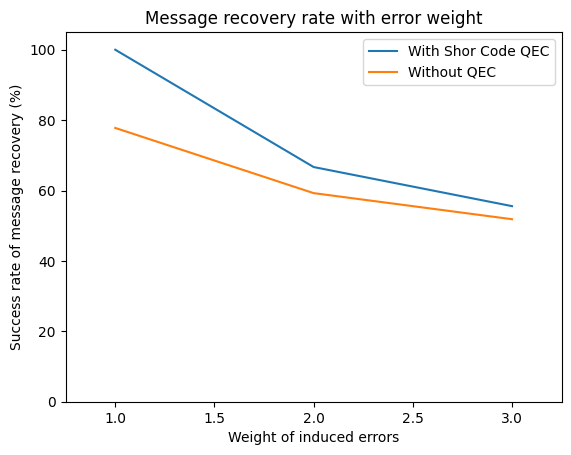

In [41]:
plt.plot(np.arange(1, 1+len(QEC_success_rates)), QEC_success_rates, label="With Shor Code QEC")
plt.plot(np.arange(1, 1+len(no_QEC_success_rates)), no_QEC_success_rates, label="Without QEC")
plt.title("Message recovery rate with error weight")
plt.xlabel("Weight of induced errors")
plt.ylabel("Success rate of message recovery (%)")
plt.ylim([0,105])
plt.xlim([0.75, len(QEC_success_rates) + 0.25])
legend = plt.legend()
legend.get_frame().set_facecolor('white')

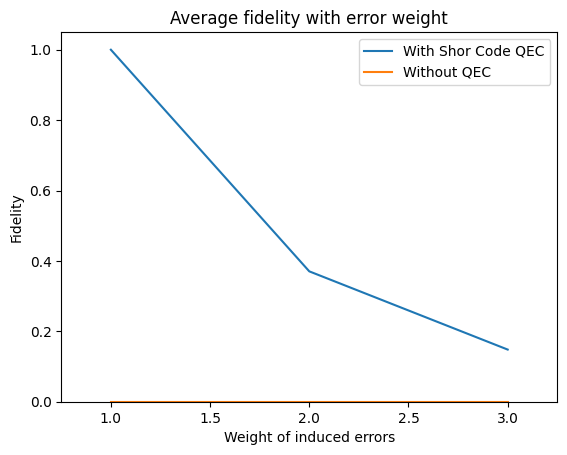

In [42]:
average_fidelities = [[np.mean(arr) for arr in QEC_fidel_ave], [np.mean(arr) for arr in no_QEC_fidel_ave]]
plt.plot(np.arange(1, 1+len(QEC_success_rates)), average_fidelities[0], label="With Shor Code QEC")
plt.plot(np.arange(1, 1+len(no_QEC_success_rates)), average_fidelities[1], label="Without QEC")
plt.title("Average fidelity with error weight")
plt.xlabel("Weight of induced errors")
plt.ylabel("Fidelity")
plt.ylim([0,1.05])
plt.xlim([0.75, len(QEC_success_rates) + 0.25])
legend = plt.legend()
legend.get_frame().set_facecolor('white')

Circuit representation:

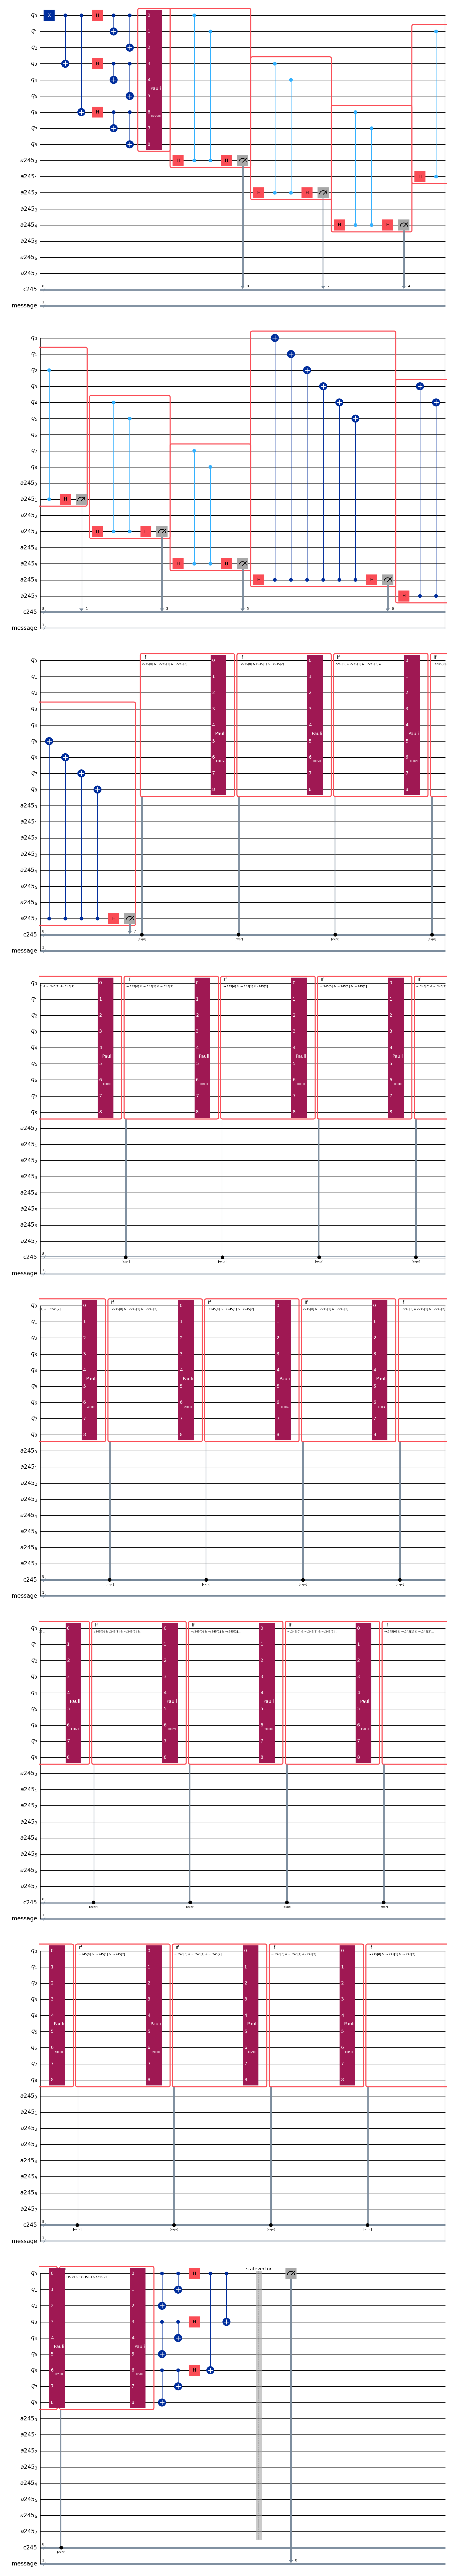

In [43]:
circuit = QuantumCircuit(9)    
circuit = encode(circuit, message)
with circuit.box(label="Noisy channel"):
    circuit.compose(error.to_instruction(), qubits=list(range(9)), inplace=True)
circuit = append_registers(circuit, stabilizers)
circuit = measure_stabilizers(circuit, stabilizers)
circuit = correct_errors(circuit, shor_code, syndromes_lookup)
circuit = unencode(circuit)
circuit.save_statevector()
circuit.measure(0, circuit.cregs[1][0])
circuit.draw(output='mpl')

### Decoding via Logical Measurement
Another way to decode a logical state is to use logical measurements. This is currently a WIP for this notebook.